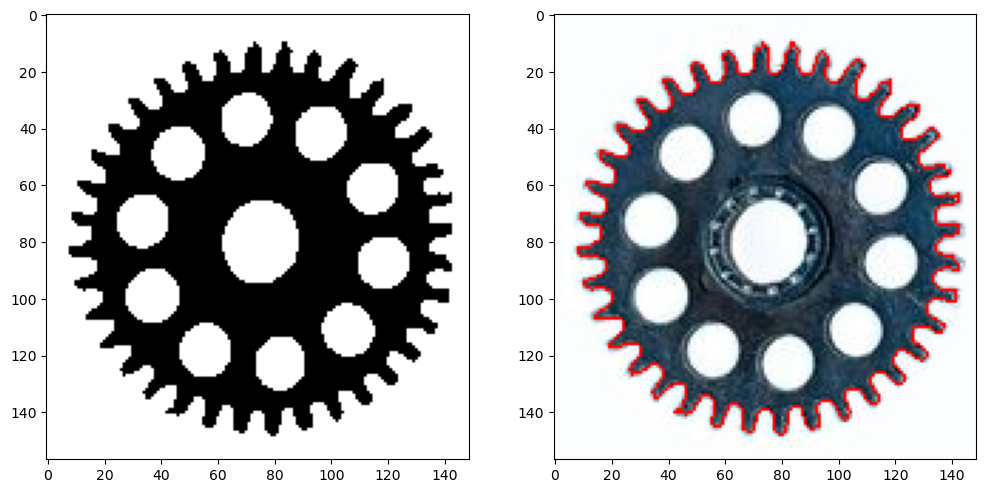

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


trybik = cv2.imread('trybik.jpg')
def draw_contours(img):
    imgG = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgG, 150, 255, cv2.THRESH_BINARY)
    closed = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, np.ones((3, 3), 
        np.uint8))
    closed_not = cv2.bitwise_not(closed)


    contours, hierarchy = cv2.findContours(closed_not, cv2.RETR_TREE,
                                            cv2.CHAIN_APPROX_NONE)

    cv2.drawContours(img, contours[0], -1, (255, 0, 0), 1)

    f, ax =plt.subplots(1, 2, figsize=(12, 8))
    ax[0].imshow(closed, 'gray')
    ax[1].imshow(img)

draw_contours(trybik)

In [7]:
import numpy as np

def get_gradients(imgGray):
    sobelx = cv2.Sobel(imgGray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(imgGray, cv2.CV_64F, 0, 1, ksize=5)
    return sobelx, sobely

def get_gradient_values(sobelx, sobely):
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    magnitude /= np.amax(magnitude)

    gradient_ori = np.arctan2(sobely, sobelx) * (180 / np.pi) % 360 
    return magnitude, gradient_ori

def distance(vector):
    return np.sqrt(vector[0]**2 + vector[1]**2)

def get_R_table(imgG):

    _, thresh = cv2.threshold(imgG, 230, 255, 
        cv2.THRESH_BINARY)
    # closed = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, np.ones((3, 3), 
    #     np.uint8))
    neg_img = cv2.bitwise_not(thresh)

    contours, hierarchy = cv2.findContours(neg_img, cv2.RETR_TREE,
                                            cv2.CHAIN_APPROX_NONE)
    
    sobelx, sobely = get_gradients(imgG)

    magnitude, gradient_ori = get_gradient_values(sobelx, sobely)

    m_dict = cv2.moments(thresh, 1)
    m00 = m_dict['m00']
    m01 = m_dict['m01']
    m10 = m_dict['m10']
    C = (int(m10/m00), int(m01/m00))

    R_table = [[] for _ in range(360)]

    for contour in contours[:1]:
        for point in contour:
            x, y = point.ravel()
            r = np.sqrt((x - C[0])**2 + (y - C[1])**2)
            theta = np.arctan2(y - C[1], x - C[0]) * (180 / np.pi) % 360
            gradient_angle = int(gradient_ori[y, x])
            R_table[gradient_angle].append((r, theta))

    # for point in contours[0]:
    #         x, y = point[0]
    #         vector = np.array([x - C[0], y - C[1]])
    #         dist = np.linalg.norm(vector)
    #         angle = np.arctan2(vector[1], vector[0])
    #         orientation = int(gradient_ori[y, x])
    #         R_table[orientation].append((dist, angle))
            # alfa_cur = int(alfa[i] - 1)

            # vector = np.array(i) - np.array(C)
            # angle_rad = np.arctan2(vector[1], vector[0])
            # angle = np.degrees(angle_rad)
            # angle += 180

            # dist = distance(vector)

            # val = (dist, int(angle)-1)
            # R_table[alfa_cur].append(val)
            
    return R_table

In [8]:
trybik = cv2.imread('trybik.jpg')
trybikG = cv2.cvtColor(trybik, cv2.COLOR_BGR2GRAY)
R_table = get_R_table(trybikG)

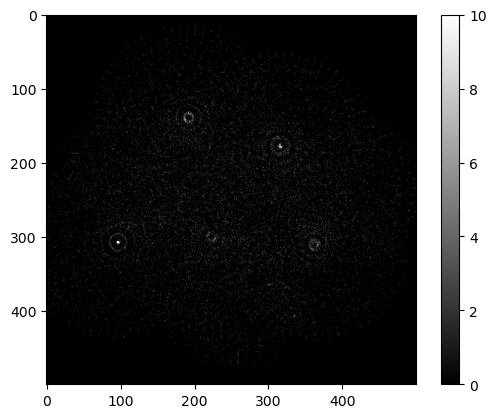

In [19]:
trybiki2_orig = cv2.imread('trybiki2.jpg')


# trybiki2 = cv2.imread('trybiki2.jpg', cv2.IMREAD_GRAYSCALE)
trybiki2 = cv2.cvtColor(trybiki2_orig, cv2.COLOR_BGR2GRAY)

# R_table = get_R_table(trybiki2)
sobelx2, sobely2 = get_gradients(trybiki2)
magnitude2, gradient_ori2 = get_gradient_values(sobelx2, sobely2)
# magnitude, _ = get_gradient_values(sobelx2, sobely2)
# gradient_ori = np.arctan2(sobely2, sobelx2) * (180/np.pi) % 360

hough_space = np.zeros(trybiki2.shape)
for y in range(trybiki2.shape[0]):
    for x in range(trybiki2.shape[1]):
        if magnitude2[y, x] > 0.5:
            gradient_angle = int(gradient_ori2[y, x])
            for r, theta in R_table[gradient_angle]:
                x1 = int(x - r * np.cos(np.deg2rad(theta)))
                y1 = int(y - r * np.sin(np.deg2rad(theta)))
                if 0 <= x1 < hough_space.shape[1] and 0 <= y1 < hough_space.shape[0]:
                    hough_space[y1, x1] += 1

plt.imshow(hough_space, cmap='gray', vmax=10)
plt.colorbar()
plt.show()

# H = np.zeros_like(trybiki2).astype(np.float32)

# for y in range(trybiki2.shape[0]):
#     for x in range(trybiki2.shape[1]):
#         if magnitude[y, x] > 0.5:
#             orientation  =int(gradient_ori[y, x])
#             for r, fi in R_table[orientation]:
#                 x1 = int(-r*np.cos(fi) + x)
#                 y1 = int(-r*np.sin(fi) + y)
#                 if 0 < x1 < H.shape[1] and 0 < y1 < H.shape[0]:
#                     H[x1, y1] += 1

# m_y, m_x = np.where(H.max() == H)
# plt.plot([m_x], [m_y], '*', color='r')

# plt.imshow(trybiki2, 'gray')
# plt.show()
# plt.imshow(H, 'gray')
# plt.show()


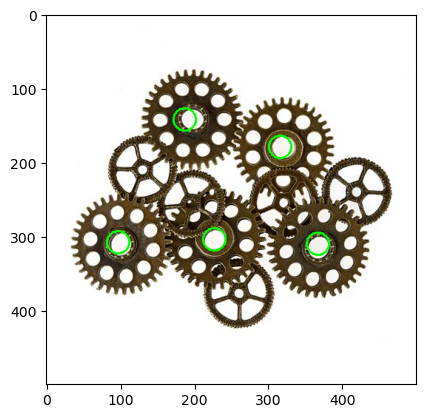

In [20]:
img_cpy = trybiki2_orig.copy()

for i in range(5):
    y, x = np.where(hough_space == np.max(hough_space))
    y, x = y[0], x[0]
    cv2.circle(img_cpy, (x, y), 15, (0, 255, 0), 2)
    hough_space[y-80:y+80, x-80:x+80] = 0
    hough_space = cv2.GaussianBlur(hough_space, (5, 5), 0)

plt.imshow(cv2.cvtColor(img_cpy, cv2.COLOR_BGR2RGB))
plt.show()
